# Import Statements

In [204]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [32]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import itertools

# Dataset Importing

In [98]:
url = 'covid_data.csv'
column_names = ['Country (label)', 'Date (label)', 'new_cases', 'new_deaths', 'new_tests', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index']

raw_dataset = pd.read_csv(url, names=column_names, sep=',')

In [99]:
dataset = raw_dataset.copy()
dataset.head()

,Country (label),Date (label),new_cases,new_deaths,new_tests,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,human_development_index
0,1,1,25.0,0.0,0.0,67.59,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498
1,1,2,26.0,0.0,0.0,67.59,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498
2,1,3,43.0,0.0,0.0,67.59,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498
3,1,4,0.0,0.0,0.0,67.59,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498
4,1,5,35.0,1.0,0.0,78.70,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.498


# Filtering and Cleaning

In [249]:
#Only one unique entry per country
dataset = dataset.drop_duplicates(subset='Country (label)').reset_index(drop=True)

In [250]:
nulls_per_row = dataset.isnull().sum(axis=1)
rows_to_drop = nulls_per_row >= 5

dataset = dataset[~rows_to_drop]
dataset = dataset.dropna(axis=1)

# Clustering Evaluaton and Processing

In [306]:
#Number of clusters used in evaluation, will be changed in iterations. Varies from 1 to 100.
cluster_number = 1

In [310]:
feature_array = dataset.to_numpy()

In [311]:
#Unsupervised learning, so we only consider the data points and not the labels themselves. Also eliminate new cases, new deaths
#new tests, stringency index, don't seem as relevant. Maybe add new cases.
feature_array = feature_array[:, 6:]
feature_array.shape

(164, 8)

In [312]:
sc = StandardScaler()

In [313]:
cluster_labels_full_list = []
silhouette_score_full_list = []
combo_list = []

for i in range(1, 9):
    combo_list.append(list(itertools.combinations(range(8), i)))

In [ ]:
for j in range(2, 50):
    cluster_number = j
    cluster_labels_full_list.append([])
    silhouette_score_full_list.append([])
    for k in range(len(combo_list)):
        feature_subset_list = combo_list[k]
        cluster_labels_full_list[j - 2].append([])
        silhouette_score_full_list[j - 2].append([])
        for l in range(len(feature_subset_list)):
            feature_indices = list(feature_subset_list[l])
            feature_subset = feature_array[:, feature_indices]
            sc.fit(feature_subset)
            feature_subset = sc.transform(feature_subset)
            kmeans = KMeans(init='k-means++', n_clusters=cluster_number, random_state=0).fit(feature_subset)
            cluster_labels = kmeans.fit_predict(feature_array)
            sil_score = silhouette_score(feature_subset,cluster_labels)
            cluster_labels_full_list[j - 2][k].append(cluster_labels)
            silhouette_score_full_list[j - 2][k].append(sil_score)

In [276]:
cluster_list = np.tile(np.arange(2, 11),(3,1)).flatten('F').tolist()
sil_min_list = []
label_assignment_min_list = []
feature_subset_min_list = []

for w in range(2, 50):
    cluster_labels_partial = cluster_labels_full_list[w - 2]
    silhouette_score_partial = silhouette_score_full_list[w - 2]
    for x in range(len(combo_list)):
        feature_subset_list = combo_list[x]
        cluster_np = np.asarray(cluster_labels_partial[x])
        silhouette_score_np = np.asarray(silhouette_score_partial[x])
        sil_min = np.amin(silhouette_score_np)
        sil_argmin = np.argmin(silhouette_score_np)
        labels_min = cluster_np[sil_argmin, :]
        sil_min_list.append(sil_min)
        label_assignment_min_list.append(labels_min.tolist())
        feature_subset_min_list.append(list(feature_subset_list[sil_argmin]))

# Data Visualizations

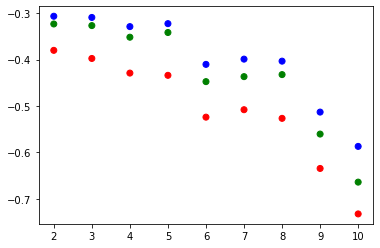

In [278]:
colors = ['red' if x%3 == 0 else 'green' if x % 3 == 1 else 'blue' for x,v in enumerate(sil_min_list)]
plt.scatter(cluster_list, sil_min_list, color=colors)

In [279]:
cumulative_min_sil_score = min(sil_min_list)
min_label_assignment = label_assignment_min_list[np.argmin(np.asarray(sil_min_list))]
min_feature_subset = feature_subset_min_list[np.argmin(np.asarray(sil_min_list))]

In [281]:
print(cumulative_min_sil_score)
print(min_label_assignment)
print(min_feature_subset)

-0.732415262758298
[4, 2, 4, 6, 2, 4, 2, 6, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 6, 6, 6, 4, 2, 2, 6, 6, 7, 4, 2, 2, 6, 2, 2, 2, 0, 2, 2, 2, 6, 0, 2, 2, 2, 2, 0, 2, 2, 4, 2, 2, 2, 0, 6, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 1, 3, 0, 4, 2, 2, 4, 2, 8, 2, 6, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 2, 6, 2, 2, 2, 8, 2, 2, 2, 6, 6, 4, 2, 6, 6, 2, 2, 6, 5, 2, 2, 5, 2, 2, 2, 2, 6, 0, 4, 2, 2, 6, 8, 2, 2, 2, 6, 6, 2, 2, 2, 2, 2, 4, 4, 4, 6, 4, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 0, 4, 4, 2, 4, 9, 2, 6, 6, 0, 6, 6]
[1]


In [300]:
#PCA for visualization
pcaModel = PCA(n_components=2)
pca_fit = pcaModel.fit_transform(feature_array)

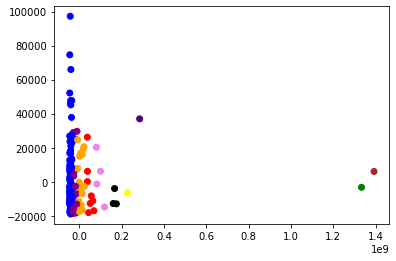

In [301]:
unique_labels = np.unique(np.asarray(min_label_assignment))
final_cluster_number = unique_labels.shape[0]
colors_2 = ['red' if x == 0 else 'green' if x == 1 else 'blue' if x == 2 else 'yellow' if x == 3 
            else 'orange' if x == 4 else 'black' if x == 5 else 'purple' if x == 6 else 'brown'
            if x == 7 else 'violet' if x == 8 else 'indigo' for x in min_label_assignment]
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], color=colors_2)

In [302]:
min_features_qualitative = dataset.columns[(np.asarray(min_feature_subset) + 6).tolist()]
min_features_qualitative_list = list(min_features_qualitative)
print(min_features_qualitative_list)
print(final_cluster_number)

['population_density']
10


# Unsupervised Learning Conclusion

Most optimal clustering occurs when only one feature is considered - 'population_density'- with 10 clusters. The cluster assignment is indicated as per the graph above, and the resulting minimum silhouette score is -0.732415262758298.